In [68]:
import random as rd
import numpy as np
import scipy as sp

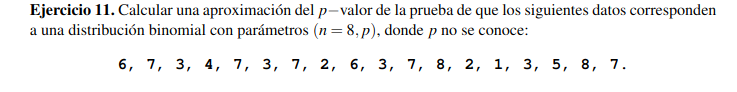

Tenemos una muestra $Y_1, Y_2, \cdots, Y_n$, que toman valores en el conjunto {1, 2, 3, 4, 5, 6, 7, 8}. Y quiero ver si los datos provienen de una variable X ~ Bin(n=8, p) donde no conozco el valor de p.

Si X ~ Bin(n=8, p), entonces:
$$
p_i = P(X = i) = \binom{8}{i} p^i (1-p)^{8-i}
$$

La Esperanza de X estara dada por: $E(X) = np = 8p$. Entonces utilizo el estimador de la media poblacional para estimar p:

In [69]:
data = np.array([6, 7, 3, 4, 7, 3, 7, 2, 6, 3, 7, 8, 2, 1, 3, 5, 8, 7], dtype=float)
print(round(np.mean(data),4))

4.9444


Entonces tengo:
$$
\begin{align*}
E(X) &= 8p \\
4.9444 &= 8p \\
\hat{p} &= 0.618
\end{align*}
$$

Ahora debo agrupar los valores de la muestra junto con sus frecuencias, se debe agrupar tal que la frecuencia es >= 3. Si un unico valor no cumple con la condicion, se debe agrupar con el valor mas cercano y la probabilidad se calculara como P(X > i) o P(X < i) segun corresponda.

In [70]:
values, frec = np.unique(data, return_counts=True)
print(values)
print(frec)

[1. 2. 3. 4. 5. 6. 7. 8.]
[1 2 4 1 1 2 5 2]


Podemos hacer los siguientes grupos:
- los que toman valores menores o iguales a 2. N = 3
- los que toman valor 3, N = 4
- los que toman valores entre 4 y 6, N = 4
- los que toman valores mayores o iguales a 7 N = 7

Ahora debo calcular las siguientes probabilidades utilizando $\hat{p} = 0.618$:
$$
P(X \leq 2) = P(X = 0) + P(X = 1) + P(X = 2) \\
P(X = 3) = \binom{8}{i} p^3 (1-p)^{8-3} \\
P(4 \leq X \leq 6) = P(X = 4) + P(X = 5) + P(X = 6) \\
P(X \geq 7) = 1 - P(X < 7) \\
= 1 - P(X = 0) - P(X = 1) - P(X = 2) - P(X = 3) - P(X = 4) - P(X = 5) - P(X = 6)
$$

Calculo las probabilidades:

In [71]:
n = 8
p_hat = 0.618
print(round(sp.stats.binom.cdf(2, n, p_hat),4))
print(round(sp.stats.binom.pmf(3, n, p_hat),4))
print(round(sp.stats.binom.cdf(6, n, p_hat)-sp.stats.binom.cdf(3, n,p_hat),4))
print(round(1 - sp.stats.binom.cdf(6, n, p_hat),4))

0.0396
0.1075
0.7264
0.1265


Ahora teniendo un estimador para p, las frecuencias y probabilidades para cada agrupamiento, puedo calcular el estadistico de prueba:

In [72]:
def estadistico(n, pi,Ni):
    t = 0
    for i in range(len(Ni)):
        t += ((Ni[i] - n*pi[i])**2)/(n*pi[i])
    return t

def calcular_pvalor_param(t, k, m):
    return 1 - sp.stats.chi2.cdf(t, k-1-m)

In [73]:
n = 18 # TAMAÑO DE LA MUESTRA
Ni = [3.0, 4.0, 4.0, 7.0] # FRECUENCIAS OBSERVADAS
pi = [0.0396, 0.1075, 0.7264, 0.1265] # PROBABILIDADES PARA CADA GRUPO
k = 4 # CANTIDAD DE GRUPOS
m = 1 # PARAMETROS ESTIMADOS

t = estadistico(n, pi, Ni)
print(round(t,4))
print(calcular_pvalor_param(t, k, m))

25.6382
2.7085010531058273e-06


Ahora para hacer una simulacion debo generar N muestras de tamaño 18 y de una Bin(8, 0.618) y calcular un nuevo $\hat{p_{sim}}$ y recalcular el estadistico de prueba.

In [74]:
def gen_muestra(N, n, p):
    return [sp.stats.binom.rvs(n, p) for i in range(N)]

In [81]:
def estimar_pvalor(nsims, n, p_hat, pi, Ni):
    t_est = 0
    t = estadistico(n, pi, Ni)
    p_sim = p_hat
    Ni_m = [0, 0, 0, 0]
    pi_m = [0, 0, 0, 0]
    for i in range(nsims):
        muestra = gen_muestra(n, 8, p_sim) # genero una nueva muestra de tamaño n
        for obs in muestra:
            if obs <= 2:
                Ni_m[0] += 1
            elif obs == 3:
                Ni_m[1] += 1
            elif obs <= 6: # entre 4 y 6
                Ni_m[2] += 1
            else: # mayor que 7
                Ni_m[3] += 1
        # Ya tengo las frecuencias de la nueva muestra por grupo, 
        # ahora debo calcular el p_sim
        p_sim = np.mean(muestra)/8 
        # ahora recalculo las probabilidades
        pi_m[0]=round(sp.stats.binom.cdf(2, 8, p_sim),4)
        pi_m[1]=round(sp.stats.binom.pmf(3, 8, p_sim),4)
        pi_m[2]=round(sp.stats.binom.cdf(6, 8, p_sim)-sp.stats.binom.cdf(3, 8,p_sim),4)
        pi_m[3]=round(1 - sp.stats.binom.cdf(6, 8, p_sim),4)
        print(pi_m)
        print(Ni_m)

        t1 = estadistico(n, pi_m, Ni_m)  # calculo un nuevo estadistico

        if t1 >= t:
            t_est += 1

    return t_est/nsims

In [82]:
nsims = 1000
n = 18 # tamaño de la muestra
p_hat = 0.618 # estimador de p con datos iniciales
Ni = [3.0, 4.0, 4.0, 7.0] # frecuencias observadas de muestra inicial
pi = [0.0396, 0.1075, 0.7264, 0.1265] # probabilidades de muestra inicial 
print(estimar_pvalor(nsims, n, p_hat, pi, Ni))

[0.0157, 0.0587, 0.7067, 0.2188]
[0, 2, 11, 5]
[0.0197, 0.0683, 0.717, 0.1951]
[0, 4, 25, 7]
[0.0219, 0.0734, 0.7208, 0.1839]
[1, 5, 37, 11]
[0.0197, 0.0683, 0.717, 0.1951]
[1, 5, 52, 14]
[0.0473, 0.12, 0.7219, 0.1108]
[3, 6, 66, 15]
[0.0898, 0.1733, 0.6747, 0.0622]
[3, 11, 79, 15]
[0.1445, 0.2187, 0.6016, 0.0352]
[7, 13, 90, 16]
[0.1445, 0.2187, 0.6016, 0.0352]
[8, 19, 101, 16]
[0.1841, 0.2415, 0.5499, 0.0246]
[11, 24, 111, 16]
[0.1189, 0.1999, 0.636, 0.0453]
[13, 27, 124, 16]
[0.0965, 0.18, 0.6659, 0.0576]
[15, 29, 138, 16]
[0.0965, 0.18, 0.6659, 0.0576]
[16, 35, 148, 17]
[0.1736, 0.2361, 0.5633, 0.0269]
[21, 38, 158, 17]
[0.2178, 0.256, 0.5078, 0.0185]
[25, 43, 167, 17]
[0.2422, 0.2641, 0.4786, 0.0151]
[28, 51, 174, 17]
[0.2178, 0.256, 0.5078, 0.0185]
[32, 56, 183, 17]
[0.1445, 0.2187, 0.6016, 0.0352]
[34, 60, 195, 17]
[0.1356, 0.2126, 0.6135, 0.0383]
[37, 63, 206, 18]
[0.1949, 0.2466, 0.5361, 0.0224]
[41, 66, 217, 18]
[0.1949, 0.2466, 0.5361, 0.0224]
[45, 70, 227, 18]
[0.0715, 0.15

/tmp/ipykernel_11278/1861835612.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  t += ((Ni[i] - n*pi[i])**2)/(n*pi[i])


[0.0075, 0.0349, 0.6558, 0.3018]
[483, 397, 1339, 463]
[0.014, 0.0542, 0.7004, 0.2314]
[483, 397, 1354, 466]
[0.0157, 0.0587, 0.7067, 0.2188]
[483, 398, 1368, 469]
[0.0124, 0.05, 0.6931, 0.2445]
[484, 399, 1379, 474]
[0.0176, 0.0634, 0.7123, 0.2067]
[484, 399, 1396, 475]
[0.0269, 0.0841, 0.726, 0.163]
[484, 401, 1410, 477]
[0.0243, 0.0786, 0.7238, 0.1733]
[484, 402, 1423, 481]
[0.036, 0.1014, 0.7275, 0.135]
[484, 404, 1437, 483]
[0.036, 0.1014, 0.7275, 0.135]
[486, 404, 1451, 485]
[0.0243, 0.0786, 0.7238, 0.1733]
[486, 405, 1465, 488]
[0.0515, 0.1265, 0.7185, 0.1035]
[487, 407, 1478, 490]
[0.0773, 0.1598, 0.6906, 0.0724]
[489, 408, 1491, 492]
[0.0773, 0.1598, 0.6906, 0.0724]
[490, 410, 1506, 492]
[0.0834, 0.1665, 0.683, 0.0672]
[492, 412, 1519, 493]
[0.0773, 0.1598, 0.6906, 0.0724]
[493, 415, 1533, 493]
[0.1189, 0.1999, 0.636, 0.0453]
[495, 418, 1545, 494]
[0.1538, 0.2247, 0.5892, 0.0322]
[497, 422, 1557, 494]
[0.0834, 0.1665, 0.683, 0.0672]
[498, 426, 1568, 496]
[0.0834, 0.1665, 0.683